In [1]:
import numpy as np
import random

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from tqdm import tqdm
from tqdm import trange
import time

import os
import math
from math import sin
from icecream import ic
import json
import argparse

# checklist 1: uncomment matplotlib.use('Agg')
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
# plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline  

# plt.style.use('dark_background')

from scipy.io import loadmat
import scipy
from scipy import signal
from scipy.fftpack import fft, ifft
from scipy.signal import hilbert, chirp
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

i_seed = 0

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
from torchsummary import summary

import PIL

import sys

sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from plotting_tools import *
# from preprocessing import *
# from feature_extraction import *
# from data_pulling import *
# from setting import *
# from surrogate_extraction import *
# from evaluate import *
# from training_util import *
# from dataset_util import *
# from evaluation_util import *

from plotting_tools import *
from preprocessing import *
from setting import *
from surrogate_extraction import *
from dataIO import *
from filters import *
from spectral_module import *
from stage4_regression import *
# from unet_extension.dataset_util import *
# from unet_extension.evaluation_util import *
# from unet_extension.models import *
# from unet_extension.training_util import *


import datetime
import time

# checklist 2: comment out all magic command
from importlib import reload
%load_ext autoreload
%autoreload 2


In [2]:
# Fs = FS_RESAMPLE

# label_names = ['br', 'heart_rate_cosmed', 'rer', 'vco2_ml_min', 've', 'vo2_ml_min', 'vt']
# sig_names = ['ECG', 'accelX', 'accelY', 'accelZ']

In [3]:
parser = argparse.ArgumentParser(description='RR_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--training_params_file', metavar='training_params_file', help='training_params_file',
                    default='training_params_list.json')

parser.add_argument('--experiment_name', metavar='experiment_name', help='experiment_name',
                    default='baseline')


# checklist 3: comment first line, uncomment second line
# args = parser.parse_args(['--input_folder', '../../../covid/results/stage3/win60_overlap95_seq20_ECG_AMpt_norm_script1/', 
args = parser.parse_args(['--input_folder', '../../data/stage4_FL/', 
                          '--output_folder', '../../data/stage5_FL/',
#                           '--experiment_name', 'regressor'])
#                           '--experiment_name', 'FFTRegression'])
#                           '--experiment_name', 'RespiratoryRegression'])
                          '--experiment_name', 'baseline67'])
                          
# args = parser.parse_args()
print(args)

Namespace(experiment_name='baseline67', input_folder='../../data/stage4_FL/', output_folder='../../data/stage5_FL/', training_params_file='training_params_list.json')


In [4]:
inputdir = args.input_folder
outputdir = args.output_folder
experiment_name = args.experiment_name

# outputdir = outputdir+inputdir.split('/')[-2]+'/'

# training_params_file = args.training_params_file

In [5]:
inputdir

'../../data/stage4_FL/'

In [6]:
os.listdir(inputdir)

['FFTRegression',
 'RespiratoryRegression',
 'shortWin',
 'computation',
 'training_logs.txt',
 '.ipynb_checkpoints',
 'baseline67',
 'baseline']

In [7]:
# sweep_name = '2blocks-ECG+scgZ-weight1+0-8ch-act0-DominantFreqRegression'
# int(sweep_name.split('-')[0].split('blocks')[0])


# auxillary_weight = int(sweep_name.split('-')[2].split('weight')[1].split('+')[0])
# adversarial_weight = int(sweep_name.split('-')[2].split('weight')[1].split('+')[1])
# # int(sweep_name.split('-')[2].split('weight')[1])
# int(sweep_name.split('-')[3].split('ch')[0])
# inputdir_act.split('/')[-2]
# int(sweep_name.split('-')[4].split('act')[1])
# sweep_name.split('-')[5]

In [8]:
df_performance_agg = pd.DataFrame()


for act_name in os.listdir(inputdir):
#     if act_name!='baseline' and act_name!='stairrecovery':
    if act_name!=experiment_name:
        continue

    inputdir_act = inputdir+act_name+'/'


    for sweep_name in os.listdir(inputdir_act):
        if 'blocks' not in sweep_name:
            continue
#         if '3blocks-scgZ+ECG' not in sweep_name:
#             continue

    #     df_performance = pd.read_csv(inputdir+'3blocks-scgZ+ECG-weight5-8ch/numeric_results/df_performance_val_HR_patch-scgZ.csv')
        df_performance = pd.read_csv(inputdir_act + sweep_name + '/numeric_results/df_performance_val_HR_patch-scgZ.csv')

        df_performance['n_block'] = int(sweep_name.split('-')[0].split('blocks')[0])
        df_performance['signals'] = sweep_name.split('-')[1]
#         df_performance['loss_weight'] = int(sweep_name.split('-')[2].split('weight')[1])
        df_performance['auxillary_weight'] = int(sweep_name.split('-')[2].split('weight')[1].split('+')[0])
        df_performance['adversarial_weight'] = int(sweep_name.split('-')[2].split('weight')[1].split('+')[1])        
        df_performance['n_channel'] = int(sweep_name.split('-')[3].split('ch')[0])
        df_performance['activity'] = inputdir_act.split('/')[-2]
        df_performance['act_id'] = int(sweep_name.split('-')[4].split('act')[1])
        df_performance['regressor_name'] = sweep_name.split('-')[5]
        
        
        df_performance_agg = df_performance_agg.append(df_performance)

    df_performance_agg = df_performance_agg.reset_index(drop=True)

In [9]:
np.sort(df_performance_agg['CV'].unique()), np.sort(df_performance_agg['CV'].unique()).shape

(array([101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 113, 114, 115,
        116, 117, 118, 119, 120, 121]),
 (19,))

In [10]:
df_performance_agg.shape[0]/19, df_performance_agg['n_block'].unique()

(9.0, array([4, 3, 2]))

In [11]:
# act_mask = (df_performance_agg['n_block']==3) & (df_performance_agg['n_channel']==8) & (df_performance_agg['adversarial_weight']==1) & (df_performance_agg['adversarial_weight']==0)
act_mask = (df_performance_agg['adversarial_weight']==0) & (df_performance_agg['adversarial_weight']==0)

df_performance_agg_masked = df_performance_agg[act_mask]

In [12]:
# df_performance_agg_masked

In [13]:
df_performance_agg_masked.shape[0]/19

9.0

/home/mchan/miniconda3/envs/mienv/lib/python3.7/site-packages/seaborn/categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'loss weight')

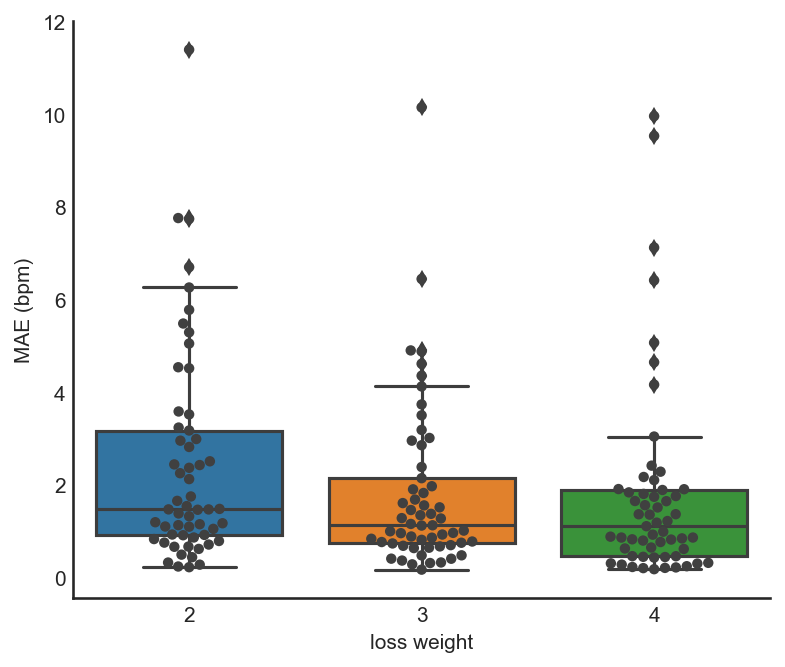

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=150)

hue_name = None
x_name = 'n_block'
y_name = 'mae'
# act_mask = df_performance_agg['activity']=='baseline'

sns.boxplot(data=df_performance_agg_masked, x=x_name, y=y_name, ax=ax, hue=hue_name)
sns.swarmplot(data=df_performance_agg_masked, x=x_name, y=y_name, color=".25",split=True, ax=ax, hue=hue_name)

ax_no_top_right(ax)
ax.set_ylabel('MAE (bpm)')
ax.set_xlabel('loss weight')

In [15]:
metric_name = 'mae'
metric_name = 'PCC'

var_name = 'n_block'

# act_mask = df_performance_agg['n_block']!=2

for var in np.sort(df_performance_agg_masked[var_name].unique()):
    

    
#     mask = (df_performance_agg['activity']=='baseline') & (df_performance_agg['loss_weight']==loss_weight)
    mask = df_performance_agg_masked[var_name]==var

    metric_mean, metric_std =  df_performance_agg_masked[mask][metric_name].mean(), df_performance_agg_masked[mask][metric_name].std()
    
    print('{}={}\t{}={:.2f} ({:.2f})'.format(var_name, var, metric_name, metric_mean, metric_std))
#     print('{:.2f} ({:.2f})'.format( metric_mean, metric_std))

n_block=2	PCC=0.69 (0.39)
n_block=3	PCC=0.81 (0.34)
n_block=4	PCC=0.77 (0.37)


In [39]:
metric_name = 'mae'
# metric_name = 'PCC'
# metric_name = 'rmse'

var_name1 = 'n_block'
var_name2 = 'n_channel'

# act_mask = df_performance_agg['n_block']!=2

for var1 in np.sort(df_performance_agg_masked[var_name1].unique()):
    for var2 in np.sort(df_performance_agg_masked[var_name2].unique()):
    

    
    #     mask = (df_performance_agg['activity']=='baseline') & (df_performance_agg['loss_weight']==loss_weight)
        mask =( df_performance_agg_masked[var_name1]==var1 )  & ( df_performance_agg_masked[var_name2]==var2)

        metric_mean, metric_std =  df_performance_agg_masked[mask][metric_name].mean(), df_performance_agg_masked[mask][metric_name].std()

        print('{}={}\t{}={}\t{}={:.2f} ({:.2f})'.format(var_name1, var1, var_name2, var2, metric_name, metric_mean, metric_std))
    #     print('{:.2f} ({:.2f})'.format( metric_mean, metric_std))

n_block=2	n_channel=4	mae=2.74 (2.19)
n_block=2	n_channel=8	mae=2.65 (2.99)
n_block=2	n_channel=16	mae=1.91 (1.50)
n_block=3	n_channel=4	mae=2.02 (2.28)
n_block=3	n_channel=8	mae=1.77 (1.80)
n_block=3	n_channel=16	mae=1.63 (1.26)
n_block=4	n_channel=4	mae=2.12 (2.55)
n_block=4	n_channel=8	mae=1.75 (1.70)
n_block=4	n_channel=16	mae=1.43 (2.08)


In [17]:
df_performance_agg_masked[mask]

,CV,task,Rsquared,PCC,rmse,mae,mape,n_block,signals,auxillary_weight,adversarial_weight,n_channel,activity,act_id,regressor_name
38,107,HR_patch-scgZ,-10.691242,0.850228,1.576249,1.557310,0.024093,4,scgZ,0,0,16,baseline67,0,DominantFreqRegression
39,121,HR_patch-scgZ,0.943109,0.972535,0.382093,0.297251,0.003992,4,scgZ,0,0,16,baseline67,0,DominantFreqRegression
40,117,HR_patch-scgZ,-3.440582,0.719077,2.419470,2.281054,0.024466,4,scgZ,0,0,16,baseline67,0,DominantFreqRegression
41,101,HR_patch-scgZ,-3.341103,0.890569,1.784232,1.739289,0.022135,4,scgZ,0,0,16,baseline67,0,DominantFreqRegression
42,102,HR_patch-scgZ,-2.516526,-0.286676,2.469318,1.885686,0.026028,4,scgZ,0,0,16,baseline67,0,DominantFreqRegression
43,103,HR_patch-scgZ,0.830965,0.977036,0.350215,0.312715,0.003324,4,scgZ,0,0,16,baseline67,0,DominantFreqRegression
44,104,HR_patch-scgZ,0.885456,0.992363,1.913306,1.648028,0.017965,4,scgZ,0,0,16,baseline67,0,DominantFreqRegression
45,105,HR_patch-scgZ,0.807403,0.954134,0.503079,0.426848,0.006029,4,scgZ,0,0,16,baseline67,0,DominantFreqRegression
46,106,HR_patch-scgZ,-7.205274,0.277216,1.057651,0.793339,0.008968,4,scgZ,0,0,16,baseline67,0,DominantFreqRegression
47,108,HR_patch-scgZ,-0.557430,0.975583,1.938650,1.905647,0.025864,4,scgZ,0,0,16,baseline67,0,DominantFreqRegression


In [40]:
# df_performance = pd.read_csv('../../../Estimation_EE/data/stage4_FL/RespiratoryRegression/6blocks-scgZ-weight0+0-8ch-act0-RespiratoryRegression/numeric_results/df_performance_val_HR_patch-scgZ.csv')
# df_performance = pd.read_csv('../../../Estimation_EE/data/stage4_FL/baseline/3blocks-ECG+scgZ-weight1+0-8ch-act0-DominantFreqRegression/numeric_results/df_performance_val_HR_patch-scgZ.csv')

In [44]:
# df_performance['rmse'].mean(), df_performance['rmse'].std()

In [18]:
# df_performance_agg[mask][metric_name]

In [19]:
# import numpy as np
# import matplotlib.pyplot as plt

# a = 1
# theta = np.linspace(0, 2*np.pi, 100)

# # We could replace the next three lines with:
# # y, x = np.mgrid[-3*a:3*a:1000j, -3*a:3*a:1000j]
# x = np.linspace(-3*a, 3*a, 1000)
# y = np.linspace(-3*a, 3*a, 1000)
# x, y = np.meshgrid(x, y)

# # Now let's make something similar to your V for this example..
# r = np.hypot(x, y)
# V = np.cos(3*np.arctan2(y, x)) + np.sin(r) + np.cos(x)*1j * np.cos(r)

# def plot(ax, data):
#     ax.plot(a*np.cos(theta), a*np.sin(theta), color='black')
#     im = ax.imshow(data, extent=[x.min(), x.max(), y.max(), y.min()], cmap='viridis')
#     fig.colorbar(im, ax=ax, shrink=0.5)

# fig, (ax1, ax2) = plt.subplots(ncols=2)

# ax1.set(title='Real Portion')
# plot(ax1, V.real)

# x_arr = np.arange(0,100)/30
# y_arr = np.sin(x_arr)
# ax1.plot(x_arr, y_arr)


# ax2.set(title='Imaginary Portion')
# plot(ax2, V.imag)

# plt.show()

In [21]:
# b.shape


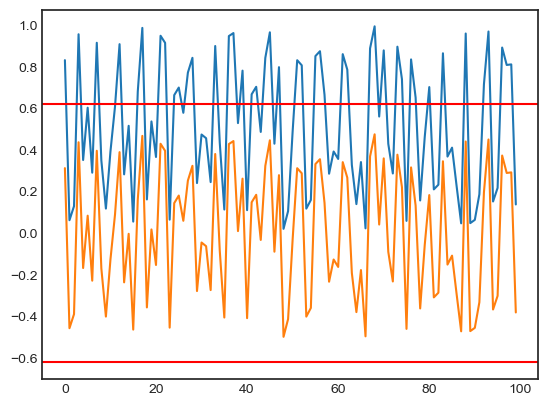

In [22]:
def clip_to_std(data, N_std=2):
    
    data = data-np.mean(data, axis=-1)[:,:,None]
    clip_thre = np.std(data, axis=-1)[:,:,None]*N_std

    data = np.clip(data, -clip_thre, clip_thre)
    return data, clip_thre



a = np.random.rand(3,2,100)

a_clipped, clip_thre = clip_to_std(a, N_std=2)



plt.plot(a[0,0,:])
plt.axhline(clip_thre[0,0,:], color='red')
plt.axhline(-clip_thre[0,0,:], color='red')
plt.plot(a_clipped[0,0,:],)

# a
# array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# np.clip(a, 1, 8)
# array([1, 1, 2, 3, 4, 5, 6, 7, 8, 8])
# np.clip(a, 8, 1)
# array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
# np.clip(a, 3, 6, out=a)
# array([3, 3, 3, 3, 4, 5, 6, 6, 6, 6])
# a
# array([3, 3, 3, 3, 4, 5, 6, 6, 6, 6])
# a = np.arange(10)
# a
# array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# np.clip(a, [3, 4, 1, 1, 1, 4, 4, 4, 4, 4], 8)
# array([3, 4, 2, 3, 4, 5, 6, 7, 8, 8])

In [23]:
# steps_thre = 100
# list_modalitites = ['SCG', 'PPG', 'ECG', 'SCGPPG', 'ECGSCG', 'ECGPPG', 'All', 'combo']
# # list_method = ['ST', 'U-Net', 'U-Net RQI_fft', 'U-Net RQI_kurtosis']
# # list_TF_types = ['source', 'FT_top', 'FT_top2', 'FT_all', 'target']


# # list_modalitites = ['PPG', 'ECG', 'SCG']

# list_method = ['ST', 'U-Net']

# list_TF_types = ['source', 'target']
# domain_name = 'CDC_dataset'
# # domain_name = 'GT_dataset'


In [ ]:
sys.exit()

In [24]:
activity_names = ['baseline', ]

In [25]:
for activity_names in os.listdir(inputdir):
    print(activity_names)

    if os.path.isdir(activity_names):
        print(activity_names)
        
#     if 'dummy' in activity_names:
#         continue
#     if 'training_logs' in activity_names:
#         continue
#     if 'ipynb_checkpoints' in activity_names:
#         continue
#     print(activity_names)
    
#     for folder_name in os.listdir(inputdir+activity_names+'/'):
#         print('\t', folder_name)

FFTRegression
RespiratoryRegression
shortWin
computation
training_logs.txt
.ipynb_checkpoints
.ipynb_checkpoints
baseline67
baseline


In [26]:

df_outputlabel_ALL_train = pd.DataFrame()

# for sub_file in os.listdir(inputdir):
#     if '.ipynb_checkpoints'==sub_file:
#         continue
        
for modalitity in list_modalitites:
        
    for TF_type in list_TF_types:
        
#         modalitity = sub_file

        csv_dir = inputdir + domain_name + '/' + modalitity + '/win60_overlap95_seq20_norm/{}/numeric_results/df_outputlabel_train_RR_cosmed.csv'.format(TF_type)
        try:
            df_outputlabel_train_RR_cosmed = pd.read_csv(csv_dir)  
        except:
            print(modalitity, 'directory does not exist')
            continue
        df_outputlabel_train_RR_cosmed['RQI_ideal'] = -np.abs(df_outputlabel_train_RR_cosmed['label_est'] - df_outputlabel_train_RR_cosmed['label'])

        df_outputlabel_train_RR_cosmed['modality'] = modalitity
        df_outputlabel_train_RR_cosmed['est_method'] = 'U-Net'
        df_outputlabel_train_RR_cosmed['TF_type'] = TF_type

        df_outputlabel_ALL_train = df_outputlabel_ALL_train.append(df_outputlabel_train_RR_cosmed)

NameError: name 'list_modalitites' is not defined

In [27]:
def get_RQI_threshold(df_outputlabel, RQI_name, steps_thre=10):
    # this function computes the threshold for RQI (defined as the value requires to get MAE<1BPM)
    df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
    MAE_diff = df_RQI_results['MAE'].values-1
#     MAE_diff = df_RQI_results['MAE'].values-1
    df_RQI_results['MAE_diff'] = MAE_diff
#     print(MAE_diff)
    
    if (MAE_diff<0).sum()!=0:
        i_RQI_threshold = np.where((MAE_diff<0) & (MAE_diff==MAE_diff[MAE_diff<0].max()))[0]
        i_RQI_threshold = i_RQI_threshold[-1]
        RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold']
    else:
        if RQI_name == 'RQI_fft':
            RQI_threshold=0.55
        elif RQI_name == 'RQI_kurtosis':
            RQI_threshold=0

#         i_RQI_threshold = MAE_diff.shape[0]//2
        
#     RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold'].values

    # i_RQI_threshold/ 
#     return RQI_threshold
    return RQI_threshold

In [28]:

def get_mask_random(N_zeros, N_ones, i_seed=0):
    # create a mask with N_zeros and N_ones
    # default seed is 0
    mask_random = [0] * N_zeros + [1] * N_ones
    random.seed(i_seed)
    random.shuffle(mask_random)
    mask_random = np.asarray(mask_random).astype(bool)
    return mask_random

def get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=10):
    
    df_RQI_results = pd.DataFrame()

    label = df_outputlabel['label'].values
    label_est = df_outputlabel['label_est'].values

    if RQI_name!='random':
        RQI_range = df_outputlabel[RQI_name].min(), df_outputlabel[RQI_name].max()
    else:
        RQI_range = [0,df_outputlabel.shape[0]]
        
        
    for threshold in np.linspace(RQI_range[0],RQI_range[1],steps_thre, endpoint=False):

        if RQI_name!='random':
            mask_RQI = df_outputlabel[RQI_name] > threshold
#             MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])
        else:
            # random rejection
            N_zeros = int(threshold)
            N_ones = df_outputlabel.shape[0] - N_zeros
            mask_RQI = get_mask_random(N_zeros, N_ones)
        
        MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])

        df_RQI_results = df_RQI_results.append(
            pd.DataFrame(
                {
                    'threshold': threshold,
                    'coverage': mask_RQI.mean()*100,
                    'MAE': MAE,
                }, index=[0]
        ))

    df_RQI_results = df_RQI_results.reset_index(drop=True)
    return df_RQI_results

# get train data, compute threshold for RQI

In [ ]:
# # Estimation_EE/data/stage4_UNet/ECG/win60_overlap95_seq20_norm/target
# csv_dir
# sub_file

In [ ]:
# os.listdir(inputdir)


In [29]:

df_outputlabel_ALL_train = pd.DataFrame()

# for sub_file in os.listdir(inputdir):
#     if '.ipynb_checkpoints'==sub_file:
#         continue
        
for modalitity in list_modalitites:
        
    for TF_type in list_TF_types:
        
#         modalitity = sub_file

        csv_dir = inputdir + domain_name + '/' + modalitity + '/win60_overlap95_seq20_norm/{}/numeric_results/df_outputlabel_train_RR_cosmed.csv'.format(TF_type)
        try:
            df_outputlabel_train_RR_cosmed = pd.read_csv(csv_dir)  
        except:
            print(modalitity, 'directory does not exist')
            continue
        df_outputlabel_train_RR_cosmed['RQI_ideal'] = -np.abs(df_outputlabel_train_RR_cosmed['label_est'] - df_outputlabel_train_RR_cosmed['label'])

        df_outputlabel_train_RR_cosmed['modality'] = modalitity
        df_outputlabel_train_RR_cosmed['est_method'] = 'U-Net'
        df_outputlabel_train_RR_cosmed['TF_type'] = TF_type

        df_outputlabel_ALL_train = df_outputlabel_ALL_train.append(df_outputlabel_train_RR_cosmed)

NameError: name 'list_modalitites' is not defined

In [ ]:
# df_outputlabel_ALL_train['']

In [ ]:
df_RQI_threshold = pd.DataFrame()

for CV in df_outputlabel_ALL_train['CV'].unique(): 
    for modality in df_outputlabel_ALL_train['modality'].unique():
        
        for TF_type in df_outputlabel_ALL_train['TF_type'].unique():
        
            df_outputlabel = df_outputlabel_ALL_train[(df_outputlabel_ALL_train['CV']==CV) & (df_outputlabel_ALL_train['modality']==modality) & (df_outputlabel_ALL_train['TF_type']==TF_type)]

#             print(df_outputlabel.shape)
#             sys.exit()
            RQI_fft_threshold = get_RQI_threshold(df_outputlabel, 'RQI_fft', steps_thre=steps_thre)
            RQI_kurtosis_threshold = get_RQI_threshold(df_outputlabel, 'RQI_kurtosis', steps_thre=steps_thre)

            df_RQI_threshold = df_RQI_threshold.append(
                pd.DataFrame(
                    {
                        'CV': CV,
                        'modality': modality,
                        'TF_type': TF_type,
                        'RQI_fft_threshold': RQI_fft_threshold,
                        'RQI_kurtosis_threshold': RQI_kurtosis_threshold,
                    }, index=[0]
                )
            )


In [ ]:
# df_RQI_threshold

In [ ]:
# training_params['freq_dict']

In [ ]:
# RQI_fft_threshold = get_RQI_threshold(df_outputlabel, 'RQI_fft', steps_thre=steps_thre)
# # RQI_kurtosis_threshold = get_RQI_threshold(df_outputlabel, 'RQI_kurtosis', steps_thre=steps_thre)


In [ ]:
# df_outputlabel['label_est']

In [ ]:
# plt.plot(df_RQI_threshold['RQI_kurtosis_threshold'].values)

# get val data

In [ ]:

df_outputlabel_ALL = pd.DataFrame()

# for sub_file in os.listdir(inputdir):
#     if '.ipynb_checkpoints'==sub_file:
#         continue
#     modalitity = sub_file
    
for modalitity in list_modalitites:
        
    for TF_type in list_TF_types:
        

#         csv_dir = inputdir + sub_file + '/win60_overlap95_seq20_norm/numeric_results/df_outputlabel_val_RR_cosmed.csv'
        csv_dir = inputdir + domain_name + '/' +  modalitity + '/win60_overlap95_seq20_norm/{}/numeric_results/df_outputlabel_val_RR_cosmed.csv'.format(TF_type)

        try:
            df_outputlabel_val_RR_cosmed = pd.read_csv(csv_dir)  
        except:
            print(modalitity, 'directory does not exist')
            continue
#         df_outputlabel_val_RR_cosmed = pd.read_csv(csv_dir)  
        df_outputlabel_val_RR_cosmed['RQI_ideal'] = -np.abs(df_outputlabel_val_RR_cosmed['label_est'] - df_outputlabel_val_RR_cosmed['label'])

#         csv_dir = inputdir + sub_file + '/win60_overlap95_seq20_norm/numeric_results/df_outputlabel_val_input_RR_cosmed.csv'
        csv_dir = inputdir + domain_name + '/' + modalitity + '/win60_overlap95_seq20_norm/{}/numeric_results/df_outputlabel_val_input_RR_cosmed.csv'.format(TF_type)

        try:
            df_outputlabel_val_input_RR_cosmed = pd.read_csv(csv_dir)  
        except:
            print(modalitity, 'directory does not exist')
            continue
            
        df_outputlabel_val_input_RR_cosmed['RQI_ideal'] = -np.abs(df_outputlabel_val_input_RR_cosmed['label_est'] - df_outputlabel_val_input_RR_cosmed['label'])

        df_outputlabel_val_input_RR_cosmed['modality'] = modalitity
        df_outputlabel_val_input_RR_cosmed['est_method'] = 'ST'
        df_outputlabel_val_input_RR_cosmed['TF_type'] = TF_type


        df_outputlabel_val_RR_cosmed['modality'] = modalitity
        df_outputlabel_val_RR_cosmed['est_method'] = 'U-Net'
        df_outputlabel_val_RR_cosmed['TF_type'] = TF_type

        df_outputlabel_ALL = df_outputlabel_ALL.append(df_outputlabel_val_input_RR_cosmed)
        df_outputlabel_ALL = df_outputlabel_ALL.append(df_outputlabel_val_RR_cosmed)

In [ ]:
# df_outputlabel_val_RR_cosmed

In [ ]:
df_outputlabel_ALL

In [ ]:
df_performance_agg = pd.DataFrame()

for modality in df_outputlabel_ALL['modality'].unique():
    for TF_type in df_outputlabel_ALL['TF_type'].unique():


        for est_method in list_method:

            for task_id in df_outputlabel_ALL['activity'].unique():
                for subject_id in df_outputlabel_ALL['CV'].unique():


                    if 'RQI' not in est_method:
                        mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['activity']==task_id) & (df_outputlabel_ALL['CV']==subject_id)
                        if mask_df.sum()==0:
                            continue
                        df_outputlabel = df_outputlabel_ALL[mask_df]
            #             MAE_mean, MAE_std = get_MAE(df_outputlabel['label'], df_outputlabel['label_est'])
                        coverage = 100

                    else:
                        mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method.split(' ')[0]) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['activity']==task_id) & (df_outputlabel_ALL['CV']==subject_id)
                        if mask_df.sum()==0:
                            continue
                        df_outputlabel = df_outputlabel_ALL[mask_df]
        #                 sys.exit()

                        mask_RQI = (df_RQI_threshold['modality']==modality) & (df_RQI_threshold['TF_type']==TF_type)
                        df_outputlabel= df_outputlabel.merge(df_RQI_threshold[mask_RQI], on=['CV'])
        #                 df_outputlabel= df_outputlabel.merge(df_RQI_threshold, on=['CV'])


                        RQI_name = est_method.split(' ')[1]
                        RQI_mask = df_outputlabel[RQI_name] > df_outputlabel[RQI_name+'_threshold']
        #                 sys.exit()
                        df_outputlabel = df_outputlabel[RQI_mask]
                        coverage = RQI_mask.mean()*100

                    if coverage==0:
                        print('coverage=0')
                        continue



                    MAE_mean, MAE_std = get_MAE(df_outputlabel['label'], df_outputlabel['label_est'])
#                     PCC = get_PCC(df_outputlabel['label'], df_outputlabel['label_est'])
#                     CoeffDeterm = get_CoeffDeterm(df_outputlabel['label'], df_outputlabel['label_est'])
                    MAPE, _ = get_MAPE(df_outputlabel['label'], df_outputlabel['label_est'])
                    RMSE = get_RMSE(df_outputlabel['label'], df_outputlabel['label_est'])

                    one_dict = {
                        'MAE_mean': MAE_mean,
                        'MAE_std': MAE_std,
#                         'PCC': PCC,
#                         'CoeffDeterm': CoeffDeterm,
                        'MAPE': MAPE*100,
                        'RMSE': RMSE,
                        'method': est_method,
                        'modality': modality,
                        'TF_type': TF_type,
                        'coverage': coverage,
                        'task': tasks_dict_reversed[task_id],
                        'subject_id': subject_id
                    }

                    df_performance_agg = df_performance_agg.append(one_dict, ignore_index=True)


In [ ]:
# df_performance_agg['modality']

In [ ]:
# df

In [ ]:

def plot_df_performance_agg(df):

    N_modality = len(df['modality'].unique())

    fig, ax = plt.subplots(1,1, figsize=(N_modality*1.5,3),dpi=100)

    # average over subjects
    sns.boxplot(data=df, x='task', y='MAE_mean', hue='modality', ax=ax, boxprops=dict(linewidth=1, alpha=0.7), showfliers = False)
    sns.stripplot(data=df, x='task', y='MAE_mean', hue='modality', ax=ax,dodge=True, size=2, color='black', alpha=0.9)

    handles, labels = ax.get_legend_handles_labels()

    # When creating the legend, only use the first two elements
    # to effectively remove the last two.
    l = plt.legend(handles[:N_modality], labels[:N_modality], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    modality = df['modality'].unique()[0]
    TF_type = df['TF_type'].unique()[0]
    
    ax.set_title('method: {}\nTF_type:{}'.format(method, TF_type))
    ax_no_top_right(ax)
    ax.set_ylim(0,10)

In [ ]:
# # df_performance_agg['TF_type'].unique()
# for TF_type in list(df_performance_agg['TF_type'].unique()):
#     print(TF_type)
    


In [ ]:


for TF_type in df_performance_agg['TF_type'].unique():
#     print(TF_type)

    for method in df_performance_agg['method'].unique():
        df = df_performance_agg[(df_performance_agg['TF_type']==TF_type) & (df_performance_agg['method']==method)]
        plot_df_performance_agg(df)


In [ ]:
# df_outputlabel[RQI_name+'_threshold']

In [ ]:
# df_performance_agg

In [ ]:
method_color_dict = {
#     'temporal': '#2471A3',
    'ST': '#45B39D',
    'U-Net':'#F4D03F' ,
    'U-Net RQI_fft':'#b34b45' ,
    'U-Net RQI_kurtosis':'#c4751b' ,
}

In [ ]:
for modality in df_outputlabel_ALL['modality'].unique():
    df = df_outputlabel_ALL[(df_outputlabel_ALL['est_method']=='U-Net') & (df_outputlabel_ALL['TF_type']=='target') & (df_outputlabel_ALL['modality']==modality)]

    
    MAE_mean, MAE_std = get_MAE(df['label'], df['label_est'])
    PCC = get_PCC(df['label'], df['label_est'])
    Rsqr = get_CoeffDeterm(df['label'], df['label_est'])
    print(modality)
    print(MAE_mean, MAE_std, PCC, Rsqr)
    # df_outputlabel_ALL['label_est']

In [ ]:
def get_df_TF_agg(df, metric='MAE_mean'):
#     df_TF_agg = df_performance_agg[df_performance_agg['method']==method].copy()
    df_TF_agg = df.pivot_table(index="TF_type", columns="modality", values=metric, aggfunc='mean')
#     df_TF_agg = df_TF_agg.loc[list_TF_types]
    df_TF_agg = df_TF_agg[list(df['modality'].unique())]
    return df_TF_agg

In [ ]:
# list_TF_types

In [ ]:

use_TEST=False

remove_moving=True

df_TF_agg = pd.DataFrame()

for method in list_method:
#     print(method)
    
    if use_TEST :
        df = df_performance_agg[ (df_performance_agg['subject_id'].isin([1, 5, 7, 15, 16, 22])) & (df_performance_agg_GT_TEST['method']==method)].copy()
    # df_performance_agg_GT_TEST = df_performance_agg
    else:
        df = df_performance_agg[df_performance_agg['method']==method].copy()

    if remove_moving:
        df = df[df['task']!='6MWT']
        
    df['TF_type'] = df['method'] + ' ' + df['TF_type']
    df_TF_agg = df_TF_agg.append(get_df_TF_agg(df, metric='MAE_mean'))
    
df_TF_agg = df_TF_agg.drop('ST source')
df_TF_agg = df_TF_agg.rename(index={'ST target':'ST'})
display(df_TF_agg)


In [ ]:
# df_copy

In [ ]:
# list_TF_types


In [ ]:
# df_copy.index = df_copy.index.astype("category")
# df_copy.index.set_categories(list_TF_types, inplace=True)


In [ ]:
df_performance_agg_copy = df_performance_agg.copy()
df_copy = df_performance_agg_copy[df_performance_agg_copy['method']=='U-Net RQI_fft'].copy()
df_copy.pivot_table(index="TF_type", columns="modality", values="MAE_mean", aggfunc='first')
# df_performance_agg_copy

In [ ]:
# df_performance_agg_copy['method'].unique()

In [ ]:
df_performance_agg_copy = df_performance_agg.copy()
df_copy = df_performance_agg_copy[df_performance_agg_copy['method']=='U-Net RQI_kurtosis'].copy()
df_copy.pivot_table(index="TF_type", columns="modality", values="MAE_mean", aggfunc='first')
# df_performance_agg_copy

In [ ]:
# df['modality'] = pd.Categorical(df['modality'],list_modalitites.reverse(), ordered=True)
# df

In [ ]:
metric_name = 'MAE_mean'

df = df_performance_agg.copy()


df['method'] = pd.Categorical(
            df['method'], 
            categories=list_method,
            ordered=True
        )
df = df.sort_values('method')


df['modality'] = pd.Categorical(
            df['modality'], 
            categories=list_modalitites.reverse(), 
            ordered=True
        )
df = df.sort_values('modality')

fig, ax = plt.subplots(1,1, figsize=(7,3),dpi=180)

sns.barplot(x="modality", y=metric_name, hue="method", data=df, ax=ax, palette=method_color_dict)
ax.yaxis.grid(True, which='major', color='gray',alpha=0.8)
ax.yaxis.grid(True, which='minor', alpha=0.5)
ax.legend(frameon=True, bbox_to_anchor=(1.05,1))

ax_no_top_right(ax)
plt.show()

In [ ]:
def plot_figure_ranking_all(df_performance_agg, outputdir=None, show_plot=False):

    fig = plt.figure(figsize=(10,10),dpi=300)
    ax = fig.add_subplot(1, 1, 1)
    fontsize = 15

    # Width of a bar 
    width = 0.2
    model_shift = 0 + width*1.5

    # ind = np.arange(len(df['input_name'].unique()))
    #     ind = np.asarray([0, 1, 2, 3, 4, 6, 5, 7])
    ind = np.arange(len(df_performance_agg['modality'].unique()))

    list_modalitites = ['SCG', 'PPG', 'ECG', 'SCGPPG', 'ECGSCG', 'ECGPPG', 'All']

    # for method in df_performance_agg['method'].unique():
    for method in ['U-Net RQI_kurtosis', 'U-Net RQI_fft', 'U-Net', 'ST']:
        df = df_performance_agg[df_performance_agg['method']==method].copy()

        df['modality'] = pd.Categorical(
            df['modality'], 
            categories=list_modalitites, 
            ordered=True
        )
        df = df.sort_values('modality')

    #     legend_name = method
    #     if method=='ST+U-Net':
    #         legend_name = 'ST-U-Net'
    #         print(df)

        ax.barh(ind+model_shift, df['MAE_mean'].values , width, label=method, color=method_color_dict[method], zorder=3, alpha=0.9)
    # ax.barh(ind, MAE_input_single,  width, label='Demodulation', color='firebrick', zorder=3, alpha=0.9)

        ax.hlines(ind+model_shift, 0, df['MAE_std'].values, color='black')  # Stems
        ax.plot(df['MAE_std'].values, ind+model_shift, 'o', color='black')  # Stem ends


#         height = rect.get_height()
#         print(df['MAE_std'].values, ind+model_shift)
    
        
#         for (x_value, y_value, coverage) in zip(df['MAE_std'].values, ind+model_shift, df['coverage']):
        for (x_value, y_value, coverage) in zip(df['MAE_mean'].values*0, ind+model_shift, df['coverage']):
            if 'RQI' not in method:
                continue
            
#             print(x_value, y_value, coverage)
            ax.text(x_value+0.05, y_value, 'cov={:.1f}%'.format(coverage), ha='left', va='center', fontsize=fontsize*0.5, color='white',weight='bold')

        
        
        model_shift = model_shift - width


    ax.set_yticks(ind + (width-0.05) / 2)
    ax.set_yticklabels(df['modality'].unique())


    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel('MAE (bpm)', fontsize=fontsize+5)

    ax.legend(fontsize=fontsize, frameon=True, bbox_to_anchor=(1.04,1))
    ax.xaxis.grid(True, which='major', color='gray',alpha=0.8)
    ax.xaxis.grid(True, which='minor', alpha=0.5)
    # plt.majorticks_on() 
    plt.minorticks_on() 

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig.tight_layout()

#         ax.set_xlim(0,4)

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + 'figure_rank_all.png', facecolor=fig.get_facecolor())
        
    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')
    plt.show()

    # plot_figure7_ranking_all(df_join_methods, outputdir=outputdir, show_plot=True)


In [ ]:
# df_performance_agg

In [ ]:
plot_figure_ranking_all(df_performance_agg, outputdir=outputdir, show_plot=True)


# RQI analysis (coverage vs. MAE)

In [ ]:
df_RQI_results_final = pd.DataFrame()

for modality in df_outputlabel_ALL['modality'].unique():
    for est_method in df_outputlabel_ALL['est_method'].unique():
        mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method)
        df_outputlabel = df_outputlabel_ALL[mask_df]
        
        for RQI_name in ['random', 'RQI_kurtosis', 'RQI_fft', 'RQI_ideal']:
            df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
            df_RQI_results['RQI_name'] = RQI_name
            df_RQI_results['est_method'] = est_method
            df_RQI_results['modality'] = modality

            df_RQI_results_final = df_RQI_results_final.append(df_RQI_results)

In [ ]:
df_RQI_results_final

In [ ]:
# df_RQI_results['RQI_name'].unique()

In [ ]:
def plot_MAEoverCoverage(ax, df_RQI_results, modality, est_method):
    fontsize = 10
    sns.lineplot(data=df_RQI_results, x="coverage", y="MAE", hue="RQI_name",ax=ax, palette=method_color_dict,alpha=0.8)
    ax.invert_xaxis()
    ax_no_top_right(ax)
    ax.set_xlim(100,50)
    ax.set_ylim(0,6)
    ax.set_xlabel('Coverage (%)', fontsize=fontsize)
    ax.set_ylabel('MAE (BPM)', fontsize=fontsize)
    ax.set_title('{} ({})'.format(modality, est_method), fontsize=fontsize+3)
    ax.legend().set_visible(False)


In [ ]:
# axes.shape

In [ ]:
# list_method
# list_modalitites
# # N_est_method, N_modality

In [ ]:
method_color_dict = {
    'random': '#999898',
    'RQI_ideal':'#433F3F' ,
    'RQI_fft':'#b34b45' ,
    'RQI_kurtosis':'#c4751b' ,
}

In [ ]:
# df_RQI_results_final['RQI_name'].unique()

In [ ]:

# N_modality
N_est_method = len(df_RQI_results_final['est_method'].unique())
N_modality = len(df_RQI_results_final['modality'].unique())

# fig, axes = plt.subplots(N_modality,N_est_method, figsize=(4,10), dpi=150)
fig, axes = plt.subplots(N_est_method, N_modality, figsize=(12,4), dpi=150)
# fig, axes = plt.subplots(N_est_method, N_modality, figsize=(20,12), dpi=150)

# for i_mod, modality in enumerate(df_RQI_results_final['modality'].unique()):
for i_mod, modality in enumerate(list_modalitites):
    for i_est, est_method in enumerate(df_RQI_results_final['est_method'].unique()):
#         print(i_mod, i_est)
        mask_df = (df_RQI_results_final['modality']==modality) & (df_RQI_results_final['est_method']==est_method)
        df_RQI_results = df_RQI_results_final[mask_df]
        ax = axes[i_est, i_mod]
        plot_MAEoverCoverage(ax, df_RQI_results, modality, est_method)
#         ax.legend( bbox_to_anchor=(1.04,1.04))
#         sys.exit()
fig.tight_layout()
# axes[0,0].plot(np.arange(5))
# axes[0,0].plot(np.arange(5))

In [ ]:
sys.exit()

In [ ]:
df_RQI_results

In [ ]:
list_modalitites

In [ ]:

# mask_df = (df_RQI_results_final['modality']=='All') & (df_RQI_results_final['est_method']=='U-Net') & (df_RQI_results_final['RQI_name']=='RQI_kurtosis')
mask_df = (df_RQI_results_final['modality']=='All') & (df_RQI_results_final['est_method']=='U-Net') & (df_RQI_results_final['RQI_name']=='RQI_fft')
df_RQI_results = df_RQI_results_final[mask_df]
plt.plot(df_RQI_results['coverage'].values, df_RQI_results['MAE'].values)

In [ ]:
df_RQI_results_final

In [ ]:
label = df_outputlabel_val_RR_cosmed['label']
label_est = df_outputlabel_val_RR_cosmed['label_est']

MAE, _ = get_MAE(label, label_est)
print(MAE)

In [ ]:
plt.plot(df_outputlabel_val_RR_cosmed['RQI_fft'])

mask_RQI_fft = df_outputlabel_val_RR_cosmed['RQI_fft'] > 0.1

In [ ]:
# df_outputlabel_val_RR_cosmed


In [ ]:
plt.plot(df_outputlabel_val_RR_cosmed['RQI_kurtosis'])

mask_RQI_kurtosis = df_outputlabel_val_RR_cosmed['RQI_kurtosis'] > 10

In [ ]:
label = df_outputlabel_val_RR_cosmed['label'][mask_RQI_fft & mask_RQI_kurtosis]
label_est = df_outputlabel_val_RR_cosmed['label_est'][mask_RQI_fft & mask_RQI_kurtosis]

MAE, _ = get_MAE(label, label_est)
print(MAE)

In [ ]:
plt.scatter(df_outputlabel_val_RR_cosmed['RQI_fft'], df_outputlabel_val_RR_cosmed['RQI_kurtosis'])

In [ ]:
mask_RQI.shape

In [ ]:
# for i in range(6):
#     mask_random = get_mask_random(2, 1, i_seed=i)
#     print(mask_random)

In [ ]:
# get_mask_random(1, 2, i_seed=1)


In [ ]:
# plt.plot(label_est)

In [ ]:
mask_random.astype(bool)

In [ ]:
# label[mask_random].shape, label.shape

In [ ]:
# RQI_fft_range
df_RQI_fft_results = pd.DataFrame()

RQI_fft_range = df_outputlabel_val_RR_cosmed['RQI_fft'].min(), df_outputlabel_val_RR_cosmed['RQI_fft'].max()

for threshold in np.linspace(RQI_fft_range[0],RQI_fft_range[1],steps_thre, endpoint=False):
    
    label = df_outputlabel_val_RR_cosmed['label'].values
    label_est = df_outputlabel_val_RR_cosmed['label_est'].values

    
    mask_RQI_fft = df_outputlabel_val_RR_cosmed['RQI_fft'] > threshold
    mask_RQI = mask_RQI_fft
    MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])
    
    N_ones = mask_RQI.sum()
    N_zeros = mask_RQI.shape[0] - mask_RQI.sum()
    
    mask_random = get_mask_random(N_zeros, N_ones)
    
#     print(mask_random.mean(), mask_RQI.mean())

#     label = df_outputlabel_val_RR_cosmed['label'][mask_random]
#     label_est = df_outputlabel_val_RR_cosmed['label_est'][mask_random]

    MAE_random, _ = get_MAE(label[mask_random], label_est[mask_random])
    
    
#     print(threshold, mask_RQI.mean(), MAE)
    
    df_RQI_fft_results = df_RQI_fft_results.append(
        pd.DataFrame(
            {
                'threshold': threshold,
                'rejection_ratio': 1-mask_RQI.mean(),
                'MAE': MAE,
                'MAE_random': MAE_random,
                
            }, index=[0]
    ))
    
df_RQI_fft_results = df_RQI_fft_results.reset_index(drop=True)

In [ ]:
threshold

In [ ]:
# RQI_fft_range
df_RQI_kurtosis_results = pd.DataFrame()

RQI_kurtosis_range = df_outputlabel_val_RR_cosmed['RQI_kurtosis'].min(), df_outputlabel_val_RR_cosmed['RQI_kurtosis'].max()

for threshold in np.linspace(RQI_kurtosis_range[0],RQI_kurtosis_range[1],steps_thre, endpoint=False):
    
    label = df_outputlabel_val_RR_cosmed['label'].values
    label_est = df_outputlabel_val_RR_cosmed['label_est'].values

    
    mask_RQI_kurtosis = df_outputlabel_val_RR_cosmed['RQI_kurtosis'] > threshold
        
    mask_RQI = mask_RQI_kurtosis
    MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])
    
    N_ones = mask_RQI.sum()
    N_zeros = mask_RQI.shape[0] - mask_RQI.sum()
    
    mask_random = get_mask_random(N_zeros, N_ones)
    
#     print(mask_random.mean(), mask_RQI.mean())

#     label = df_outputlabel_val_RR_cosmed['label'][mask_random]
#     label_est = df_outputlabel_val_RR_cosmed['label_est'][mask_random]

    MAE_random, _ = get_MAE(label[mask_random], label_est[mask_random])
    
    
#     print(threshold, mask_RQI.mean(), MAE)
    
    df_RQI_kurtosis_results = df_RQI_kurtosis_results.append(
        pd.DataFrame(
            {
                'threshold': threshold,
                'rejection_ratio': 1-mask_RQI.mean(),
                'MAE': MAE,
                'MAE_random': MAE_random,
                
            }, index=[0]
    ))
    
df_RQI_kurtosis_results = df_RQI_kurtosis_results.reset_index(drop=True)

In [ ]:
# RQI_fft_range
df_RQI_joint_results = pd.DataFrame()

RQI_kurtosis_range = df_outputlabel_val_RR_cosmed['RQI_kurtosis'].min(), df_outputlabel_val_RR_cosmed['RQI_kurtosis'].max()
RQI_fft_range = df_outputlabel_val_RR_cosmed['RQI_fft'].min(), df_outputlabel_val_RR_cosmed['RQI_fft'].max()


for threshold_fft in np.linspace(RQI_fft_range[0],RQI_fft_range[1],steps_thre, endpoint=False):

    for threshold_kurtosis in np.linspace(RQI_kurtosis_range[0],RQI_kurtosis_range[1],steps_thre, endpoint=False):

        label = df_outputlabel_val_RR_cosmed['label'].values
        label_est = df_outputlabel_val_RR_cosmed['label_est'].values

        # reject using both RQI_kurtosis and RQI_fft
        mask_RQI_kurtosis = df_outputlabel_val_RR_cosmed['RQI_kurtosis'] > threshold_kurtosis
        
        mask_RQI_fft = df_outputlabel_val_RR_cosmed['RQI_fft'] > threshold_fft
        mask_RQI = mask_RQI_kurtosis & mask_RQI_fft
        
        
        MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])

        
        # randomly reject samples
        N_ones = mask_RQI.sum()
        N_zeros = mask_RQI.shape[0] - mask_RQI.sum()

        mask_random = get_mask_random(N_zeros, N_ones)

        MAE_random, _ = get_MAE(label[mask_random], label_est[mask_random])


    #     print(threshold, mask_RQI.mean(), MAE)

        df_RQI_joint_results = df_RQI_joint_results.append(
            pd.DataFrame(
                {
                    'threshold_fft': threshold_fft,
                    'threshold_kurtosis': threshold_kurtosis,
                    'rejection_ratio': 1-mask_RQI.mean(),
                    'MAE': MAE,
                    'MAE_random': MAE_random,

                }, index=[0]
        ))

    df_RQI_joint_results = df_RQI_joint_results.reset_index(drop=True)

In [ ]:
plt.plot(df_RQI_joint_results['rejection_ratio']*100, df_RQI_joint_results['MAE'], 'r')
plt.show()

In [ ]:
plt.scatter(df_RQI_fft_results['rejection_ratio']*100, df_RQI_fft_results['MAE'], c='r', alpha=0.5)
plt.scatter(df_RQI_kurtosis_results['rejection_ratio']*100, df_RQI_kurtosis_results['MAE'], c='green', alpha=0.5)
plt.scatter(df_RQI_joint_results['rejection_ratio']*100, df_RQI_joint_results['MAE'], c='blue', alpha=0.01)

plt.show()

In [ ]:
plt.plot(df_RQI_fft_results['MAE_random'], df_RQI_fft_results['MAE'])

In [ ]:
plt.plot(df_RQI_fft_results[])

In [ ]:
sns.scatterplot(data=df_outputlabel_val_RR_cosmed, x='label', y='label_est', hue='CV', palette=subject_palette)

In [ ]:
# names_dict = {
#     'SCG_AMpt': r'SCG-PT$_{AM}$',
# #     'SCG_BW': r'SCG$_{BW}$',
# #     'PEP_FM': r'SCG$_{FM}$',
    
#     'ECG_AM': r'ECG$_{AM}$',
#     'ECG_AMr': r'ECG-R$_{AM}$',
#     'ECG_AMs': r'ECG-S$_{AM}$',
#     'ECG_AMbi': r'ECG-PP$_{AM}$',
#     'ECG_SR': r'ECG-SR$_{AM}$',
#     'ECG_AMpt': r'ECG-PT$_{AM}$',
#     'ECG_PCA': r'ECG-PCA$_{AM}$',
# #     'ECG_FM': r'ECG$_{FM}$',
# #     'ECG_BW': r'ECG$_{BW}$',
    
# #     'ECG_AMpt+ECG_AMr': r'ECG-PT$_{AM}$ + ECG-R$_{AM}$',
# #     'SCG_BW+SCG_AMpt': r'SCG$_{BW}$ + SCG-PT$_{AM}$',
# #     'ECG_AMpt+ECG_AMr+SCG_AMpt': r'ECG-PT$_{AM}$ + ECG-R$_{AM}$ + SCG-PT$_{AM}$',
#     'ECG_AMr+SCG_AMpt': r'ECG-R$_{AM}$ + SCG-PT$_{AM}$',    
# #     'ECG_AM+ECG_AMpt+ECG_AMr+ECG_AMs+ECG_AMbi+ECG_SR+SCG_AMpt': r'All ECG$_{AM}$ + SCG-PT$_{AM}$',
# #     'ECG_AM+ECG_AMpt+ECG_AMr+ECG_AMs+ECG_AMbi+ECG_SR':  r'All ECG$_{AM}$',
# #     'ECG_AMpt+ECG_AMr+ECG_AMbi+ECG_SR':  r'Good ECG$_{AM}$',
# #     'ECG_AMpt+ECG_AMr+ECG_AMbi+ECG_SR+SCG_AMpt': r'good ECG$_{AM}$ + SCG-PT$_{AM}$',
# }

In [ ]:
df_aggregated = pd.DataFrame()
for sub_file in os.listdir(inputdir):
    if 'script' in sub_file: 
        
        csv_dir = inputdir + sub_file + '/TRAIN-TEST/df_performance_TEST.csv'
#         print(csv_dir)
        
        try:
            df = pd.read_csv(csv_dir)  
            sig_name = '_'.join(sub_file.split('_')[3:-2])
            df['sig_name'] = sig_name

            df_aggregated = df_aggregated.append(df, ignore_index=True)
        except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
            print ('error when reading', sub_file)

In [ ]:
inputdir

In [ ]:
df_aggregated

In [ ]:
# filedir = '../../../covid/results/backup/stage3/win60_overlap95_seq20_ECG_AM_norm_script0/'
filedir = '../../../covid/results/stage3/win60_overlap95_seq20_ECG_AM_norm_script0/'

training_params = {}
freq = data_loader('freq', filedir)
freq_dict = dict(zip(np.arange(freq.shape[0]), freq))
training_params['freq_dict'] = freq_dict

In [ ]:
label_TRAIN = data_loader('label', filedir+'TRAIN_cosmed/')
RR_label_TRAIN = get_RR2(label_TRAIN, training_params)[:,10]*60

label_TEST = data_loader('label', filedir+'TEST/')
RR_label_TEST = get_RR2(label_TEST, training_params)[:,10]*60

In [ ]:
label_name = 'RR'

RR_range = label_range_dict['br']

fig=plt.figure(figsize=(6, 6), dpi= 120, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)

N_bins = 20

ax.hist(RR_label_TRAIN, N_bins, alpha=0.4, label='TRAIN\n  N=11\n  mean={:.2f}bpm'.format(RR_label_TRAIN.mean()), color = "firebrick")
ax.set_ylabel('count', fontsize = 20)
ax.set_xlabel(r'$RR$ (bpm)', fontsize = 20)
ax.set_title('RR samples distribution \n17 subjects, treadmill recovery ', fontsize = 20,y=1.05)
ax.tick_params(axis='x', which='major', labelsize=15)



# ax2 = fig.add_subplot(1, 2, 2)

ax.hist(RR_label_TEST, N_bins, alpha=0.4,label='TEST\n  N=6\n  mean={:.2f}bpm'.format(RR_label_TEST.mean()), color = "steelblue")

ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_xlim(RR_range)
# ax2.set_xlim(RR_range)
# ax.legend(loc='upper right', fontsize=12, frameon=True)
# ax.axis('off')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(True)

fig.tight_layout()
fig.savefig(outputdir + 'RR_distribution.png')

In [ ]:
df_aggregated = df_aggregated.sort_values(by=['MAE_mean_model_val'], inplace=False, ascending=False)
df_aggregated[['MAE_mean_model_val', 'sig_name']]
df_aggregated

In [ ]:
RR_aggregated_dict = {}
for sub_file in os.listdir(inputdir):
    if 'script' in sub_file: 
        
        csv_dir = inputdir + sub_file + '/TRAIN-TEST/df_RR_TEST.csv'
#         print(csv_dir)
        
        try:
            df = pd.read_csv(csv_dir)  
            sig_name = '_'.join(sub_file.split('_')[3:-2])
            df['sig_name'] = sig_name

#             df_RR_aggregated = df_RR_aggregated.append(df, ignore_index=True)
            RR_aggregated_dict[sig_name] = df.copy()
        except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
            print ('error when reading', sub_file)

In [ ]:
input_names = df_aggregated['sig_name'].values
MAE_model = df_aggregated['MAE_mean_model_val'].values
MAE_input = df_aggregated['MAE_mean_input_val'].values

In [ ]:
MAE_std_model = df_aggregated['MAE_std_model_val'].values
MAE_std_input = df_aggregated['MAE_std_input_val'].values

In [ ]:
def inspect_Nyquist_color(RR_label, hr, absolute_err, sig_name, names_dict, outputdir=None, show_plot=False, show_label=True):

    plt.rcParams["font.family"] = "Times New Roman"

    RR = np.linspace(label_range_dict['br'][0], label_range_dict['br'][1], 100)
    HR = np.linspace(label_range_dict['heart_rate_cosmed'][0], label_range_dict['heart_rate_cosmed'][1], 100)

    
    RR_cosmed = RR_label
    HR_cosmed = hr

    mask = RR_cosmed * 2 < HR_cosmed

    if (~mask).sum() > 0:
        print('subject {} fall out of Nyquist region'.format(subject_id))

    fig, (ax1) = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    fontsize=18

#     ax1.fill_between(HR, 0, HR/2, color='skyblue', alpha=0.2, label='Nyquist criterion\n'+r'($F_{signal}$ < $\frac{1}{2}$$F_{sampling}$)')
    ax1.fill_between(HR, 0, HR/2, color='skyblue', alpha=0.2, label='Nyquist criterion\n'+r'$\frac{HR}{RR}$ > 2')
    ax1.fill_between(HR, RR[-1], HR/2, color='gray', alpha=0.2)

    cmap = matplotlib.cm.get_cmap('jet')
    bounds=np.arange(0, 8.1, 0.05)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    
    sc = ax1.scatter(HR_cosmed[np.where(mask)], RR_cosmed[np.where(mask)], s=50, c=absolute_err, alpha=1, cmap='jet', norm=norm)

#     title_str = '{}'.format(sig_name)
    title_str = names_dict[sig_name]

    
    if show_label:
#         ax1.set_title(title_str, fontsize=fontsize, pad=15)

        ax1.set_ylabel(r'$F_{signal}$ (RR, breaths/minute)', fontsize=fontsize)
        ax1.set_xlabel(r'$F_{sampling}$ (HR, beats/minute)', fontsize=fontsize)
        ax1.legend(frameon=True, loc='upper right', fontsize=fontsize-2)

    ax1.set_xlim(HR[0], HR[-1])
    ax1.set_ylim(RR[0], RR[-1])
    ax1.tick_params(axis = 'both', which = 'major', labelsize = fontsize)

    ax1.xaxis.set_major_locator(MultipleLocator(40))
                        
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.08)

    cbar = fig.colorbar(sc, cax=cax, boundaries=bounds, 
         ticks=[0,2,4,6,8],)  
    cbar.ax.tick_params(labelsize=fontsize-2) 

    fig.tight_layout()


    if outputdir is not None:
        outputdir = outputdir+'inspect_Nyquist/'
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + '{}.png'.format(sig_name), facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')


In [ ]:
for sig_name in names_dict:

    RR_label = RR_aggregated_dict[sig_name]['RR_label'].values*60
    RR_model = RR_aggregated_dict[sig_name]['RR_model'].values*60
    hr =  RR_aggregated_dict[sig_name]['hr'].values

    absolute_err = np.abs(RR_model-RR_label)
    inspect_Nyquist_color(RR_label, hr, absolute_err, sig_name, names_dict, outputdir=outputdir, show_plot=False, show_label=True)


In [ ]:
input_names

# get temporal results from stage 2

In [ ]:
df_temporal_performance = pd.read_csv('../../../covid/results/stage2/temporal_performance.csv')
df_temporal_performance['MAE_coarse (bpm)']
df_temporal_performance

In [ ]:
df_join_methods = pd.DataFrame()


for input_name in names_dict.keys():
    df = df_aggregated[df_aggregated['sig_name']==input_name]
    

    
    
    
    one_dict = {
        'MAE_mean': df['MAE_mean_model_val'].values[0],
        'MAE_std': df['MAE_std_model_val'].values[0],
        'method': 'ST+U-Net',
        'input_name': input_name,
    }

    df_join_methods = df_join_methods.append(one_dict, ignore_index=True)
 
    one_dict = {
        'MAE_mean': df['MAE_mean_input_val'].values[0],
        'MAE_std': df['MAE_std_input_val'].values[0],
        'method': 'ST',
        'input_name': input_name,
    }

    df_join_methods = df_join_methods.append(one_dict, ignore_index=True)
 
    df = df_temporal_performance[df_temporal_performance['surrogate_name']==input_name]

    one_dict = {
        'MAE_mean': float(df['MAE_coarse (bpm)'].values[0].split('±')[0]),
        'MAE_std': float(df['MAE_coarse (bpm)'].values[0].split('±')[1]),
        'method': 'temporal',
        'input_name': input_name,
    }

    df_join_methods = df_join_methods.append(one_dict, ignore_index=True)

# {
#     'MAE_mean': ,
#     'MAE_std': ,
#     'method': ,
# }

In [ ]:
input_names

In [ ]:

# 'ECG_AMr+SCG_AMpt'
# 'SCG_AMpt', 'ECG_AM', 'ECG_AMr', 'ECG_AMs', 'ECG_AMbi', 'ECG_SR',
#        'ECG_AMpt', 

# df_join_methods['input_name'].unique()

In [ ]:

df_join_methods[df_join_methods['method']=='temporal']
df_join_methods[df_join_methods['method']=='ST']
df_join_methods[df_join_methods['method']=='ST+U-Net']

In [ ]:
df_join_methods['method'].unique()

In [ ]:
method_color_dict = {
    'temporal': '#2471A3',
    'ST': '#45B39D',
    'ST+U-Net':'#F4D03F' ,
}

In [ ]:

def get_perc_improve(new, initial):
    return (new-initial)/initial


In [ ]:
print('input name\t\t\tST v. temp\tST+U-Net v. temp\tST+U-Net v. ST')
for input_name in df_join_methods['input_name'].unique():
    df = df_join_methods[df_join_methods['input_name']==input_name]

    
    ST_improve = get_perc_improve(df[df['method']=='ST']['MAE_mean'].values[0], df[df['method']=='temporal']['MAE_mean'].values[0])
    U_improve = get_perc_improve(df[df['method']=='ST+U-Net']['MAE_mean'].values[0], df[df['method']=='temporal']['MAE_mean'].values[0])
    UST_improve = get_perc_improve(df[df['method']=='ST+U-Net']['MAE_mean'].values[0], df[df['method']=='ST']['MAE_mean'].values[0])

    print('{:20}\t\t{:.2f}%\t\t{:.2f}%\t\t\t{:.2f}%'.format(input_name, ST_improve*100, U_improve*100, UST_improve*100))

In [ ]:
print('input name\t\t\tST v. temp\tST+U-Net v. temp\tST+U-Net v. ST')
for input_name in df_join_methods['input_name'].unique():
    df = df_join_methods[df_join_methods['input_name']==input_name]

    
    ST_improve = df[df['method']=='ST']['MAE_mean'].values[0] - df[df['method']=='temporal']['MAE_mean'].values[0]
    U_improve = df[df['method']=='ST+U-Net']['MAE_mean'].values[0] - df[df['method']=='temporal']['MAE_mean'].values[0]
    UST_improve = df[df['method']=='ST+U-Net']['MAE_mean'].values[0] - df[df['method']=='ST']['MAE_mean'].values[0]

    print('{:20}\t\t{:.2f}bpm\t\t{:.2f}bpm\t\t\t{:.2f}bpm'.format(input_name, ST_improve, U_improve, UST_improve))

In [ ]:
print(input_name)

df[df['method']=='ST+U-Net']['MAE_mean'].values[0], df[df['method']=='ST']['MAE_mean'].values[0]


In [ ]:
def plot_figure7_ranking_all(df_join_methods, outputdir=None, show_plot=False):

    fig = plt.figure(figsize=(16,15),dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    fontsize = 30

    # Width of a bar 
    width = 0.25
    model_shift = 0 + width*1.5

    # ind = np.arange(len(df['input_name'].unique()))
#     ind = np.asarray([0, 1, 2, 3, 4, 6, 5, 7])
    ind = np.arange(len(df_join_methods['input_name'].unique()))

    for method in df_join_methods['method'].unique():
        df = df_join_methods[df_join_methods['method']==method]
        
        legend_name = method
        if method=='ST+U-Net':
            legend_name = 'ST-U-Net'
            print(df)
                        
        ax.barh(ind+model_shift, df['MAE_mean'].values , width, label=legend_name, color=method_color_dict[method], zorder=3, alpha=0.9)
    # ax.barh(ind, MAE_input_single,  width, label='Demodulation', color='firebrick', zorder=3, alpha=0.9)

        ax.hlines(ind+model_shift, 0, df['MAE_std'].values, color='black')  # Stems
        ax.plot(df['MAE_std'].values, ind+model_shift, 'o', color='black')  # Stem ends


        model_shift = model_shift - width


    ax.set_yticks(ind + (width+0.05) / 2)
    ax.set_yticklabels(df['input_name'].unique())


    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel('MAE (bpm)', fontsize=fontsize+5)

    ax.legend(loc='upper right', fontsize=fontsize, frameon=True)
    ax.xaxis.grid(True, which='major', color='gray',alpha=0.8)
    ax.xaxis.grid(True, which='minor', alpha=0.5)
    # plt.majorticks_on() 
    plt.minorticks_on() 

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig.tight_layout()

#     ax.set_xlim(0,4)

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + 'figure8_rank_all.png', facecolor=fig.get_facecolor())
    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')
    plt.show()

# plot_figure7_ranking_all(df_join_methods, outputdir=outputdir, show_plot=True)
plot_figure7_ranking_all(df_join_methods[(df_join_methods['input_name']!='SCG_AMpt') & (df_join_methods['input_name']!='ECG_AMr+SCG_AMpt')], outputdir=outputdir, show_plot=True)


In [ ]:
# filedir = 'covid/results/stage4/unet_TEST/win60_overlap95_seq20_ECG_AM_norm_script0/TRAIN-TEST/df_RR_TEST.csv'
# 'covid/results/stage4/unet_TEST/win60_overlap95_seq20_ECG_AMr+SCG_AMpt_norm_script13/TRAIN-TEST/df_RR_TEST.csv'

filedir = '../../../covid/results/stage4/unet_TEST/win60_overlap95_seq20_ECG_AMr+SCG_AMpt_norm_script13/TRAIN-TEST/df_RR_TEST.csv'

df_RR_TEST = pd.read_csv(filedir)  


(< 8 bpm, 9-16 bpm, 17-25 bpm, 26-38 bpm 38-60 bpm) 

In [ ]:
list_ranges = [
    [0,8], # include 0 to 8 (excluding 8)
    [8,16],
    [16,25],
    [25,38],
#     [38,60],
]

In [ ]:
# list_ranges = [
#     [0,8],
#     [8,16],
#     [16,25],
#     [25,40],
# ]

(df_RR_TEST['meta']==15).sum()

In [ ]:
# (AE==0).mean()*100 + (AE==1).mean()*100 +((AE>=2) & (AE<=3)).mean()*100 + ((AE>=4) & (AE<=6)).mean()*100 + ((AE>=7) & (AE<=9)).mean()*100 + ((AE>=10) & (AE<=15)).mean()*100 + (AE>15).mean()*100 

In [ ]:
# AE

In [ ]:
# df_aggregated = pd.DataFrame()
for sub_file in os.listdir(inputdir):
    if 'script' in sub_file: 
        
        csv_dir = inputdir + sub_file + '/TRAIN-TEST/df_RR_TEST.csv'
        
        
        if sub_file.split('seq20_')[1].split('_norm')[0] not in names_dict.keys():
            continue
        
        print('\n')
        print(csv_dir)

        try:
#             df = pd.read_csv(csv_dir)
            df_RR_TEST = pd.read_csv(csv_dir)

            # 1. compute MAE within different ranges
            for bpm_range in list_ranges:

                df_range = df_RR_TEST[(df_RR_TEST['RR_label']>=bpm_range[0]/60) & (df_RR_TEST['RR_label']<bpm_range[1]/60)]

                MAE_range = (np.abs(df_range['RR_model'] - df_range['RR_label'])).mean()*60
                print(bpm_range, MAE_range)

            # 2. compute % of segments of each bpm
            AE = np.abs(df_RR_TEST['RR_label']-df_RR_TEST['RR_model']).values*60
            AE = np.round(AE)
            print('0bpm\t1bpm\t2-3bpm\t4-6bpm\t7-9bpm\t10-15bpm\t>15bpm\t')
            print('{:.2f}\n{:.2f}\n{:.2f}\n{:.2f}\n{:.2f}\n{:.2f}\n{:.2f}'.format((AE==0).mean()*100, (AE==1).mean()*100, ((AE>=2) & (AE<=3)).mean()*100, 
                                                          ((AE>=4) & (AE<=6)).mean()*100, ((AE>=7) & (AE<=9)).mean()*100, 
                                                          ((AE>=10) & (AE<=15)).mean()*100, (AE>15).mean()*100 ))
#                                                           ((AE>2) & (AE<=6)).mean()*100))

        except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
            print ('error when reading', sub_file)

In [ ]:
input_names = df_aggregated['sig_name'].values
input_names

In [ ]:
MAE_coarse, MAE_std_coarse

In [ ]:
MAE_model.shape, MAE_std_model.shape

In [ ]:
def plot_figure7_ranking(sig_names, MAE, bar_name, names_dict, color='firebrick', outputdir=None, show_plot=False):
    sig_single = []
    i_single = []

    for i, sig_name in enumerate(sig_names):
        if sig_name not in list(names_dict.keys()):
            continue
#         if '+' in sig_name:
#             continue
#             sig_single.append(sig_name)
        sig_single.append(names_dict[sig_name])

        i_single.append(i)

    sig_names_single = np.asarray(sig_single)
    MAE_single = np.asarray(MAE[i_single])


    fig = plt.figure(figsize=(12,10),dpi=100)
#     ax = fig.add_axes([0,0,1,1])
    ax = fig.add_subplot(1, 1, 1)

    fontsize = 25


    # Position of bars on x-axis
    ind = np.arange(sig_names_single.shape[0])

    # Width of a bar 
    width = 0.7   

    ax.barh(ind, MAE_single , width, label=bar_name, color=color)

#     ax.axvline(x=6.5, color='gray', ls='--')

    
    ax.set_yticks(ind )
    ax.set_yticklabels(sig_names_single)


    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel('MAE (bpm)', fontsize=fontsize)

    ax.legend(loc='best', fontsize=fontsize, frameon=True)

    ax.xaxis.grid(True, which='major')

    fig.tight_layout()

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + 'figure7_rank_sig_{}.png'.format(bar_name), facecolor=fig.get_facecolor())
    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')
    plt.show()

In [ ]:
df_aggregated = df_aggregated.sort_values(by=['MAE_mean_input_val'], inplace=False, ascending=False)
# df_aggregated[['MAE_mean_model_val', 'sig_name']]

input_names = df_aggregated['sig_name'].values
MAE_model = df_aggregated['MAE_mean_model_val'].values
MAE_input = df_aggregated['MAE_mean_input_val'].values

MAE = MAE_input
bar_name = 'DSP'
color='firebrick'
plot_figure7_ranking(input_names, MAE, bar_name, names_dict, color=color, outputdir=outputdir, show_plot=True)


In [ ]:
df_aggregated = df_aggregated.sort_values(by=['MAE_mean_model_val'], inplace=False, ascending=False)

input_names = df_aggregated['sig_name'].values
MAE_model = df_aggregated['MAE_mean_model_val'].values
MAE_input = df_aggregated['MAE_mean_input_val'].values

MAE = MAE_model
bar_name = 'DSP + DL'
color='steelblue'
plot_figure7_ranking(input_names, MAE, bar_name, names_dict, color=color, outputdir=outputdir, show_plot=True)
